In [1]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# this function decodes our audio file
def load_wav_16k_mono(filename):
    # load encoded wav file
    file_contents = tf.io.read_file(filename)
    # decode wav (tensors by channel)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # remove trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44.1kHz to 16kHz: amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [4]:
wave = load_wav_16k_mono('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC216010-4.wav')
nWave = load_wav_16k_mono('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/curlew-sound-3.wav')

In [5]:
wave

<tf.Tensor: shape=(56000,), dtype=float32, numpy=
array([-4.2080745e-07,  6.8223898e-07, -4.4688531e-07, ...,
       -1.3327588e-02, -1.9908303e-02,  2.3853235e-02], dtype=float32)>

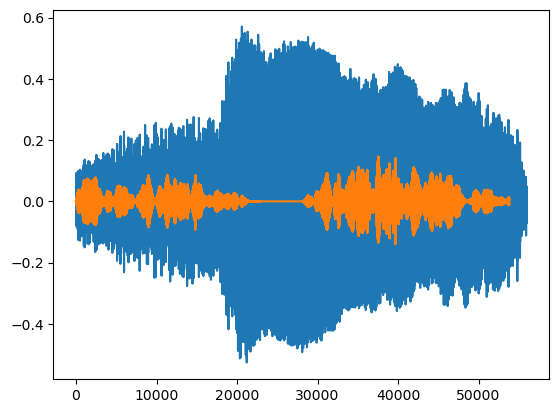

In [6]:
plt.plot(wave)
plt.plot(nWave)
plt.show()

Here blue area represents Capuchin bird
And the orange area represents every other bird

***CREATING TENSORFLOW DATASET***

Defining positive and negative path to data


In [7]:
POS = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')
NEG = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [9]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC227471-6.wav'

**Adding Labels and combining Positive and Negative Samples**

In [10]:
positive = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negative = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [11]:
tf.ones(len(pos))

<tf.Tensor: shape=(217,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [12]:
data = positive.concatenate(negative)

In [13]:
data.as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC201990-4.wav',
 1.0)

***Calcualting the Average Length of Capuchin Bird Call***

In [14]:
length=[]
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
    length.append(len(tensor_wave))

In [15]:
len(length)

217

Claculate Mean, Min, Max of Capuchin Bird Call

In [16]:
tf.math.reduce_mean(length)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
tf.math.reduce_min(length)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

**We have 16k HZ frequency which means 16000 cycle per second**

*  54156/16000 = 3.38 is average capuchin bird call time
*  32000/16000 = 2 sec is min time in length
*  80000/16000 = 5 sec is max time in length

In [19]:
48000/16000

3.0

# Pre-Processing Function to convert Audio Data into Spectogram

In [20]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)

#   As we know average lenght for time taken by Capuchin bird is 3Sec
    wav = wav[:48000]
#   We know minimum length is 32000, so we will add padding of zero to rest of left sapce
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    
#   We have to expand our dimension to train it through CNN model
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

**Test Function and visualize Spectogram**

In [21]:
filePath, label = data.as_numpy_iterator().next()

In [22]:
spectogram, label = preprocess(filePath, label)

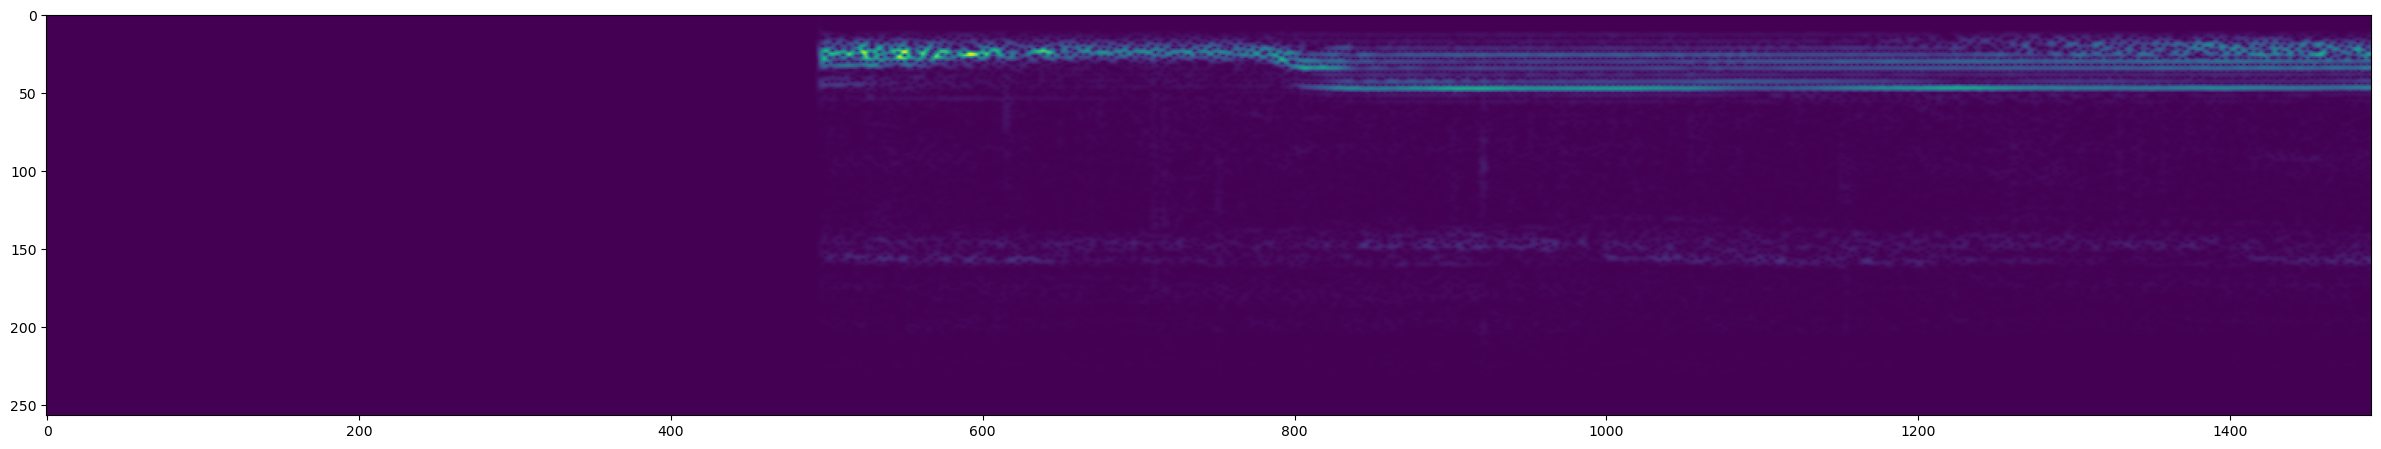

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

# Train-Test Split

**Create Tesorflow DataPipeline**

In [25]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

**Spliting into Train-Test**

In [26]:
train = data.take(36)
test = data.skip(36).take(15)

# Building Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [28]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [31]:
hist = model.fit(train, epochs=7, validation_data=test)

Epoch 1/7
36/36 [==============================] - 463s 12s/step - loss: 3.4641 - recall: 0.8477 - precision: 0.8366 - val_loss: 0.1638 - val_recall: 0.7703 - val_precision: 1.0000
Epoch 2/7
36/36 [==============================] - 429s 12s/step - loss: 0.0971 - recall: 0.9085 - precision: 0.9392 - val_loss: 0.0657 - val_recall: 1.0000 - val_precision: 0.8961
Epoch 3/7
36/36 [==============================] - 438s 12s/step - loss: 0.1107 - recall: 0.9744 - precision: 0.9744 - val_loss: 0.0424 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/7
36/36 [==============================] - 410s 11s/step - loss: 0.0342 - recall: 0.9930 - precision: 0.9930 - val_loss: 0.0011 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/7
36/36 [==============================] - 429s 12s/step - loss: 0.0035 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.7423e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/7
36/36 [==============================] - 428s 12s/step - loss: 0.0190 - recall: 0

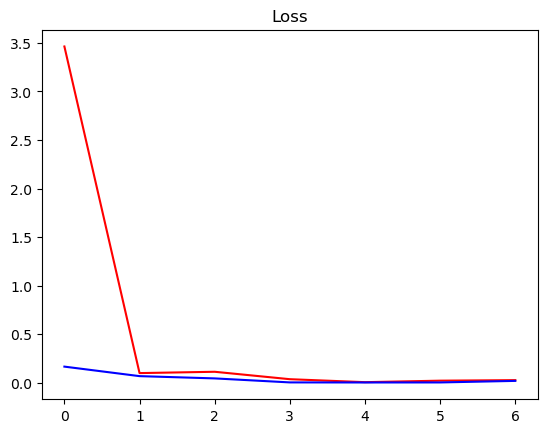

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

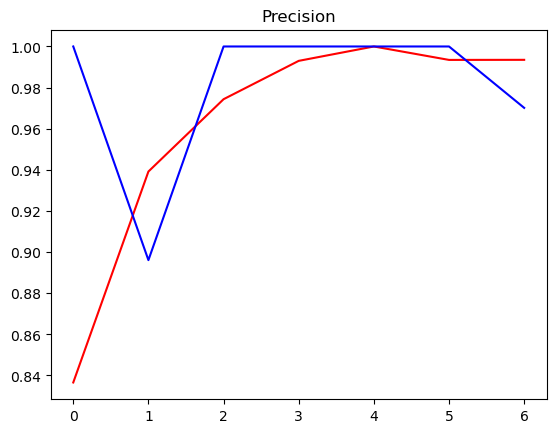

In [33]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()


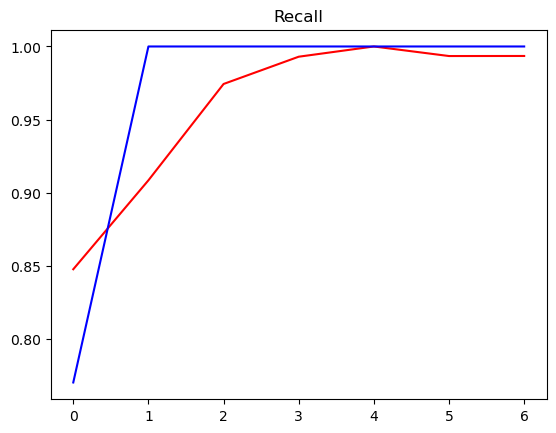

In [34]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [36]:
from tensorflow.keras.metrics import Accuracy